In [18]:
import json

# Load the 'history' file
with open('history', 'r') as file:
	history = [json.loads(line) for line in file if line.strip()]

In [19]:
from datetime import datetime
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import groupby

def parse_datetime(datetime_str):
		# 2025-03-23T17:02:56+0300 -> 2025-03-23T17:02:56+03:00
		datetime_str_fixed = datetime_str[:22] + ':' + datetime_str[22:]
		return datetime.fromisoformat(datetime_str_fixed)

def find_by_id(id):
	return next((item for item in history if item['id'] == id), None)

def plot_price_by_date(history, model):
	# Group data by car ID and prepare data for plotting
	car_data = defaultdict(list)

	for record in history:
		car_id = record['id']
		price = record['price']['usd']['amount']
		date = parse_datetime(record['downloadDate'])
		car_data[car_id].append((date, price))

	# Plot the data
	plt.figure(figsize=(12, 16))

	for car_id, data in car_data.items():
		data.sort(key=lambda x: x[0])  # Sort by date
		dates, prices = zip(*data)
		plt.plot(dates, prices, marker='o', linestyle='-')
		plt.text(dates[-1], prices[-1], f'id: {car_id}', fontsize=9, ha='left', va='center')

	plt.title(f'Цена {model} с разбивкой по id')
	plt.xlabel('Время')
	plt.ylabel('Цена')
	plt.xticks(rotation=45)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def find_insights(history):
	insights = []
	grouped_history = {key: list(group) for key, group in groupby(history, key=lambda x: x['downloadDate'])}
	dates = sorted(grouped_history.keys())
	date_pairs = list(zip(dates, dates[1:]))
	for date1, date2 in date_pairs:
		ids1 = {item['id'] for item in grouped_history[date1]}
		ids2 = {item['id'] for item in grouped_history[date2]}
		ids_added = ids2 - ids1
		ids_removed = ids1 - ids2
		price_up = {}
		price_down = {}
		for car_id in ids1 & ids2:
			price1 = next(item['price']['usd']['amount'] for item in grouped_history[date1] if item['id'] == car_id)
			price2 = next(item['price']['usd']['amount'] for item in grouped_history[date2] if item['id'] == car_id)
			if price2 - price1 > 0:
				price_up[car_id] = price2 - price1
			if price2 - price1 < 0:
				price_down[car_id] = price2 - price1
		insight = {
			'date1': date1,
			'date2': date2,
			'ids_added': [
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id)
				for car_id in ids_added
			],
			'ids_removed': [
				next(item['publicUrl'] for item in grouped_history[date1] if item['id'] == car_id)
				for car_id in ids_removed
			],
			'price_up': {
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id): price_up[car_id]
				for car_id in price_up
			},
			'price_down': {
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id): price_down[car_id]
				for car_id in price_down
			}
		}
		insights.append(insight)

	return insights

def show_insights(insights, n_last=5):
	for insight in insights[-n_last:]:
		print(f"{insight['date1']} -> {insight['date2']}")
		if insight['ids_added']:
			print(f"\t🆕: {insight['ids_added']}")
		if insight['ids_removed']:
			print(f"\t❌: {insight['ids_removed']}")
		if insight['price_up']:
			print(f"\t📈: {insight['price_up']}")
		if insight['price_down']:
			print(f"\t📉: {insight['price_down']}")
		if not (insight['ids_added'] or insight['ids_removed'] or insight['price_up'] or insight['price_down']):
			print('\tНет инсайдов')

## BMW F34 Insights

In [20]:
bmw_history = list(filter(lambda x: x['model'] == 'BMW F34', history))

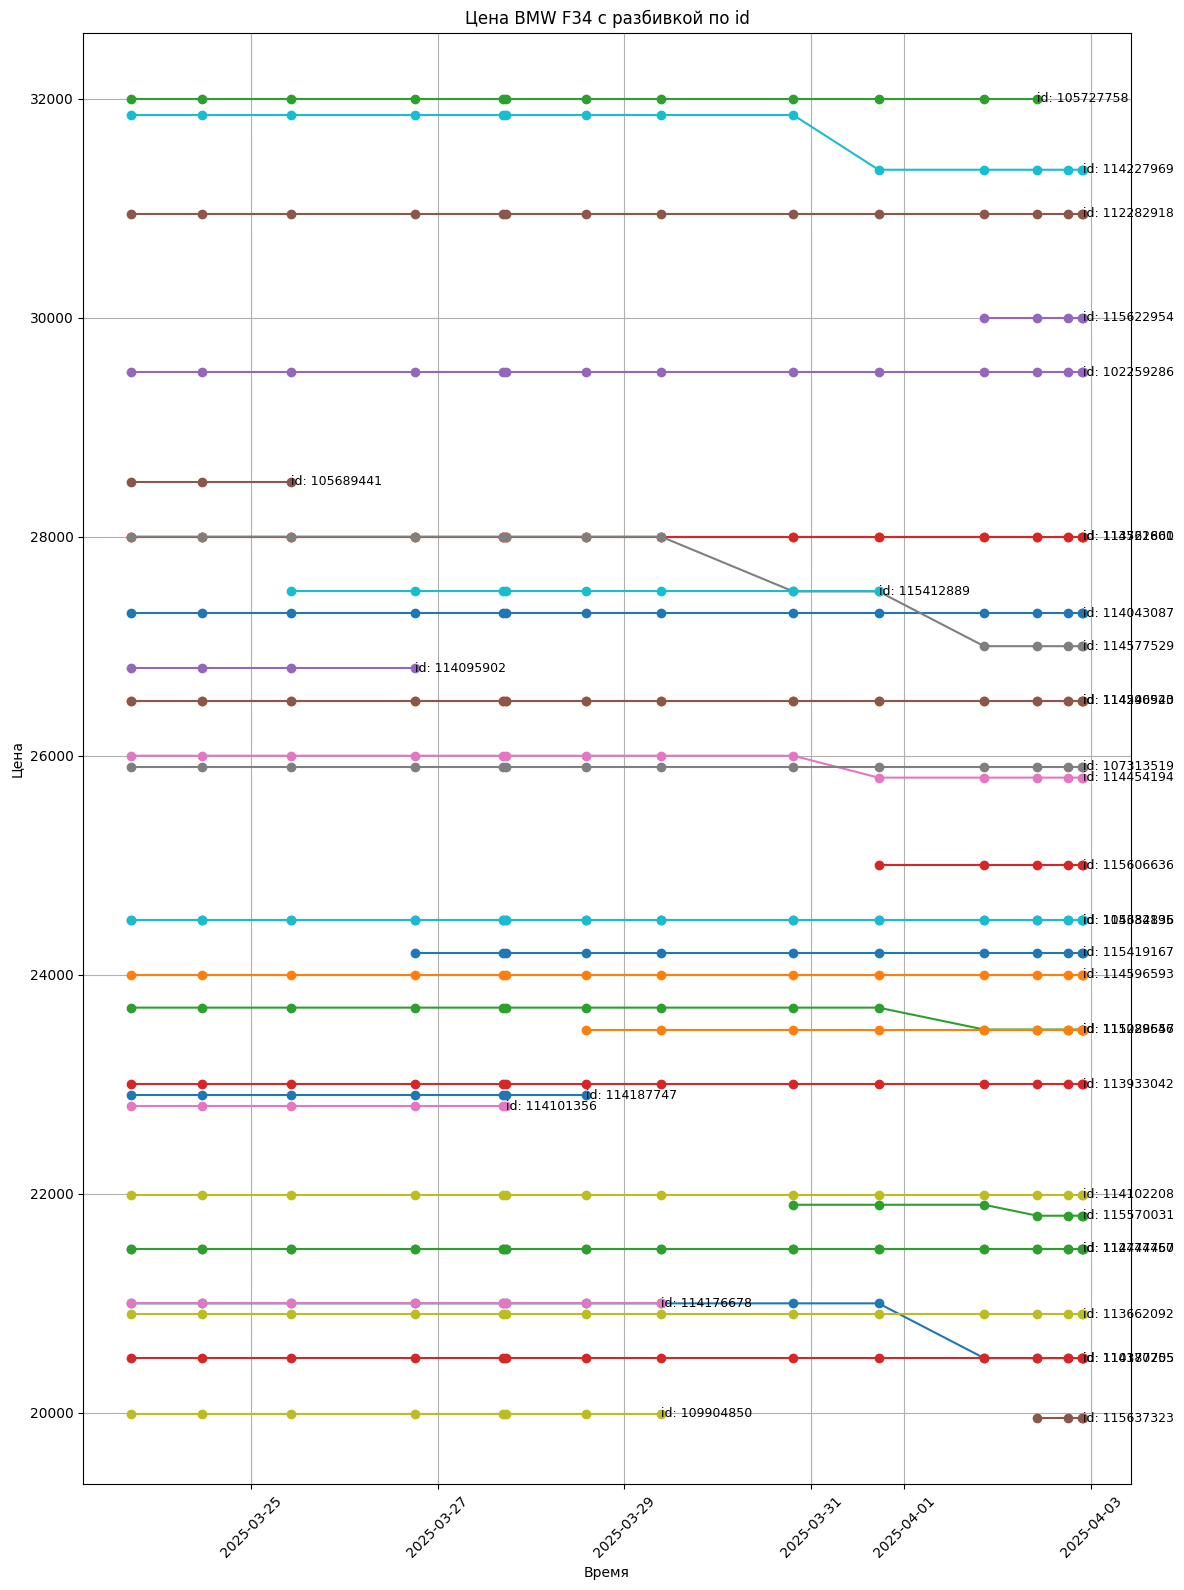

In [21]:
plot_price_by_date(bmw_history, 'BMW F34')

In [22]:
bmw_insights = find_insights(bmw_history)
show_insights(bmw_insights)

2025-03-31T17:19:26+0300 -> 2025-04-01T20:29:35+0300
	🆕: ['https://cars.av.by/bmw/3-seriya/115622954']
	❌: ['https://cars.av.by/bmw/3-seriya/115412889']
	📉: {'https://cars.av.by/bmw/3-seriya/110387255': -500, 'https://cars.av.by/bmw/3-seriya/115288557': -200, 'https://cars.av.by/bmw/3-seriya/114577529': -500}
2025-04-01T20:29:35+0300 -> 2025-04-02T10:11:18+0300
	🆕: ['https://cars.av.by/bmw/3-seriya/115637323']
	📉: {'https://cars.av.by/bmw/3-seriya/115570031': -100}
2025-04-02T10:11:18+0300 -> 2025-04-02T18:05:26+0300
	❌: ['https://cars.av.by/bmw/3-seriya/105727758']
2025-04-02T18:05:26+0300 -> 2025-04-02T21:39:15+0300
	Нет инсайдов
2025-04-02T21:39:15+0300 -> 2025-04-02T21:58:46+0300
	Нет инсайдов


## AUDI A4 B6

In [23]:
audi_history = list(filter(lambda x: x['model'] == 'AUDI A4 B6', history))

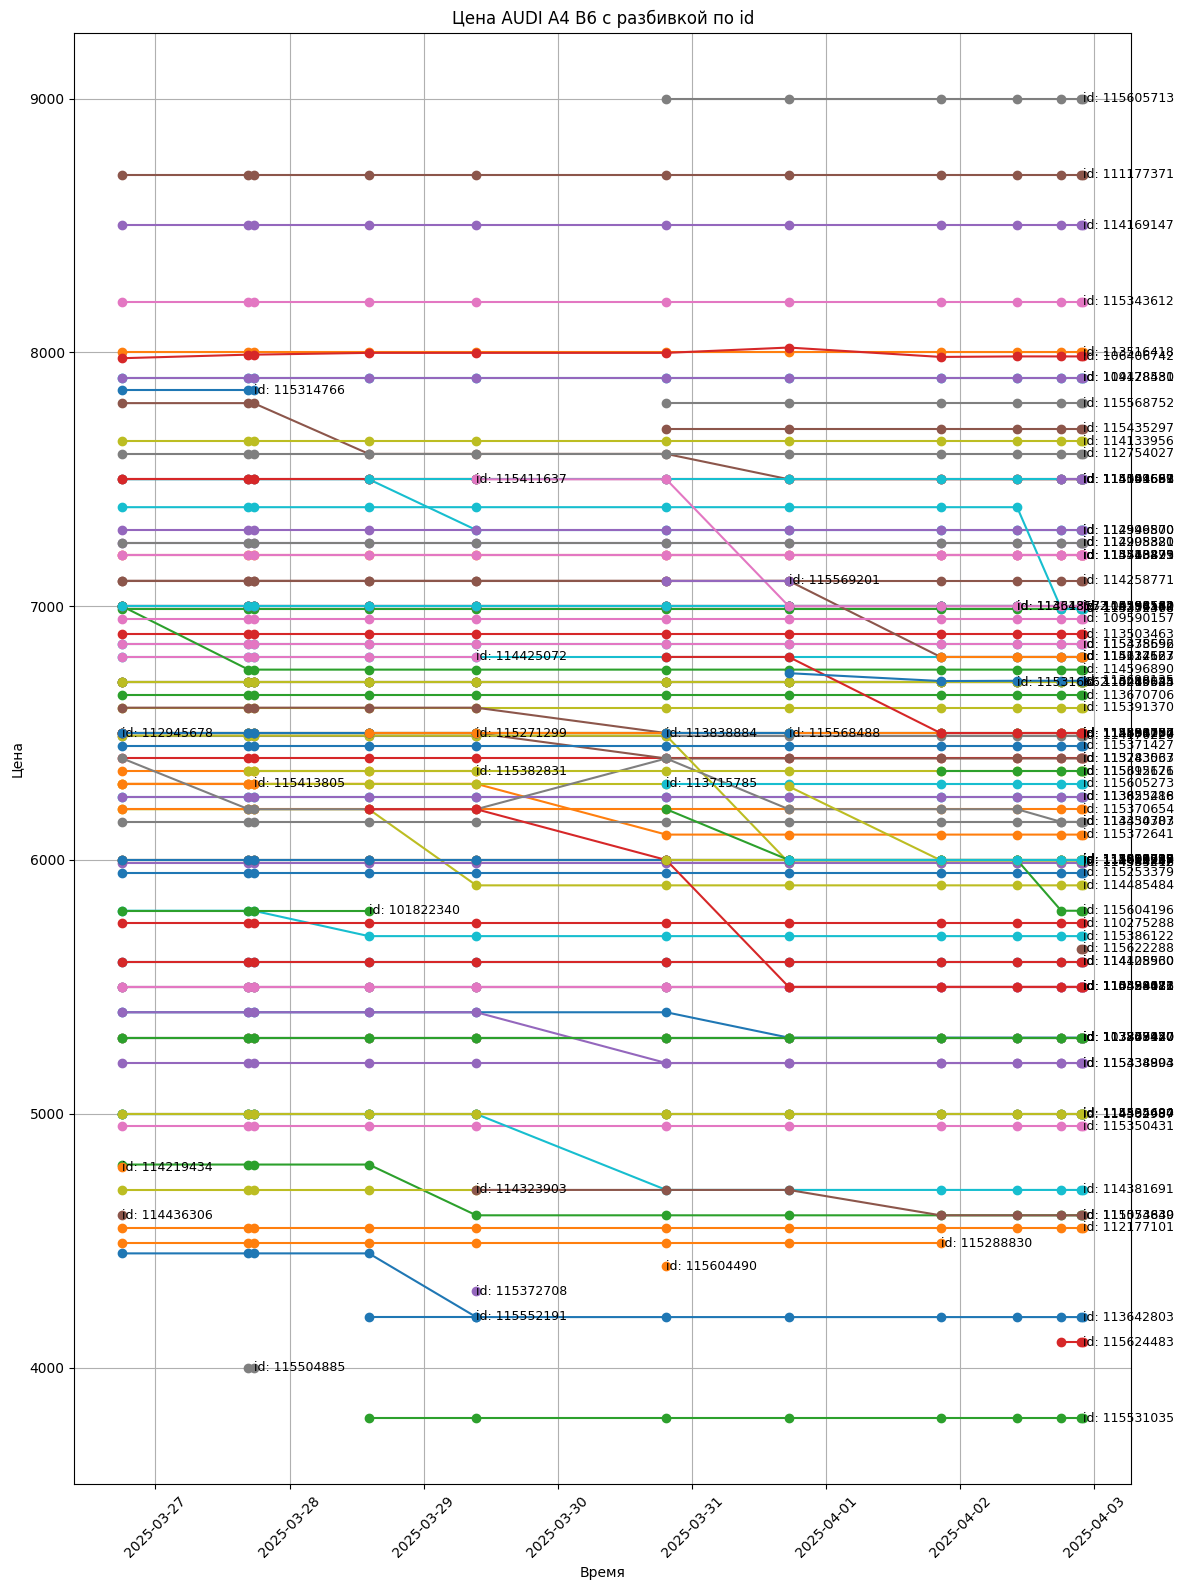

In [24]:
plot_price_by_date(audi_history, 'AUDI A4 B6')

In [25]:
audi_insights = find_insights(audi_history)
show_insights(audi_insights)

2025-03-31T17:19:26+0300 -> 2025-04-01T20:29:35+0300
	🆕: ['https://cars.av.by/audi/a4/115612171', 'https://cars.av.by/audi/a4/113720829', 'https://cars.av.by/audi/a4/115614527']
	❌: ['https://cars.av.by/audi/a4/115568488', 'https://cars.av.by/audi/a4/115569201']
	📉: {'https://cars.av.by/audi/a4/115604007': -300, 'https://cars.av.by/audi/a4/115613937': -291, 'https://cars.av.by/audi/a4/115132663': -300, 'https://cars.av.by/audi/a4/115554630': -100, 'https://cars.av.by/audi/a4/106406742': -37, 'https://cars.av.by/audi/a4/113698135': -31}
2025-04-01T20:29:35+0300 -> 2025-04-02T10:11:18+0300
	❌: ['https://cars.av.by/audi/a4/115288830']
	📈: {'https://cars.av.by/audi/a4/106406742': 2, 'https://cars.av.by/audi/a4/113698135': 1}
2025-04-02T10:11:18+0300 -> 2025-04-02T18:05:26+0300
	🆕: ['https://cars.av.by/audi/a4/115504658', 'https://cars.av.by/audi/a4/115624483']
	❌: ['https://cars.av.by/audi/a4/113643132', 'https://cars.av.by/audi/a4/114318573', 'https://cars.av.by/audi/a4/115316662']
	📉: {'

## VOLVO XC60 I

In [26]:
volvo_xc60_i_history = list(filter(lambda x: x['model'] == 'VOLVO XC60 I', history))

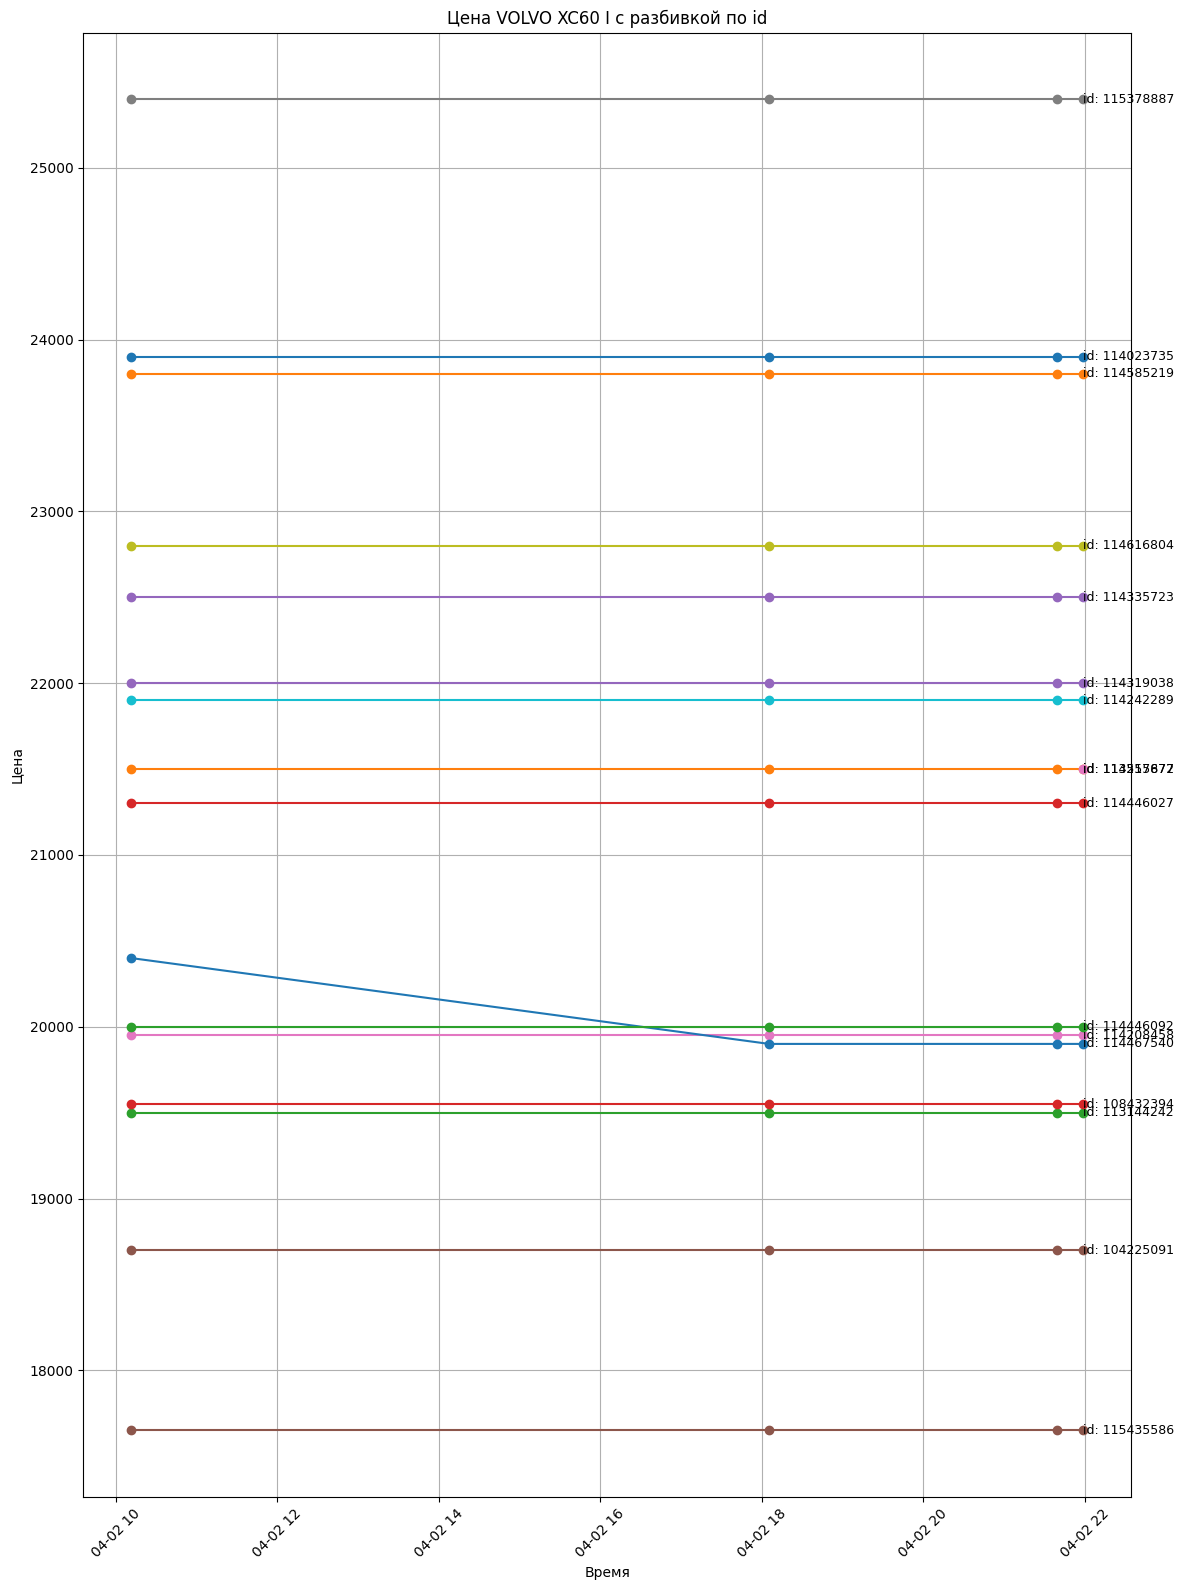

In [27]:
plot_price_by_date(volvo_xc60_i_history, 'VOLVO XC60 I')

In [28]:
volvo_xc60_i_insights = find_insights(volvo_xc60_i_history)
show_insights(volvo_xc60_i_insights)

2025-04-02T10:11:18+0300 -> 2025-04-02T18:05:26+0300
	📉: {'https://cars.av.by/volvo/xc60/114467540': -500}
2025-04-02T18:05:26+0300 -> 2025-04-02T21:39:15+0300
	Нет инсайдов
2025-04-02T21:39:15+0300 -> 2025-04-02T21:58:46+0300
	🆕: ['https://cars.av.by/volvo/xc60/113515872']


## Ford S-MAX I

In [29]:
ford_smax_i_history = list(filter(lambda x: x['model'] == 'Ford S-MAX I', history))

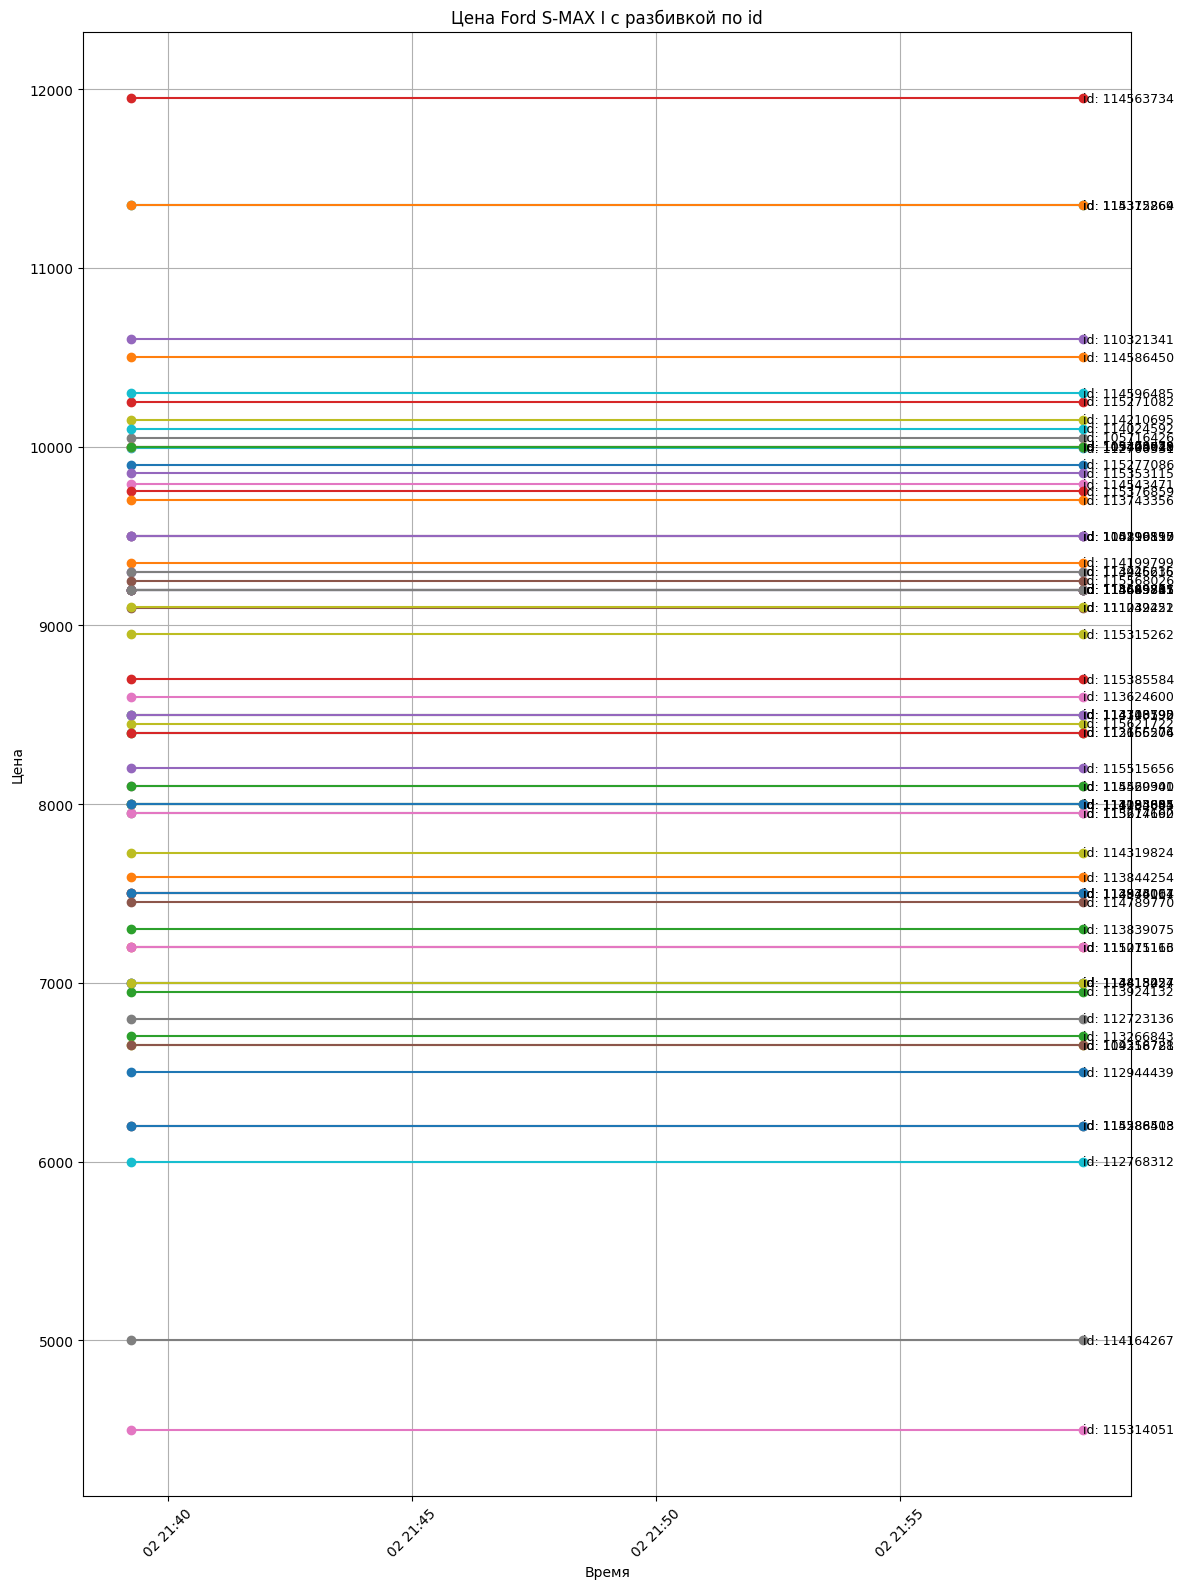

In [30]:
plot_price_by_date(ford_smax_i_history, 'Ford S-MAX I')

In [31]:
ford_smax_i_insights = find_insights(ford_smax_i_history)
show_insights(ford_smax_i_insights)

2025-04-02T21:39:15+0300 -> 2025-04-02T21:58:46+0300
	Нет инсайдов


## Kia Carnival III

In [32]:
kia_carnival_iii_history = list(filter(lambda x: x['model'] == 'Kia Carnival III', history))

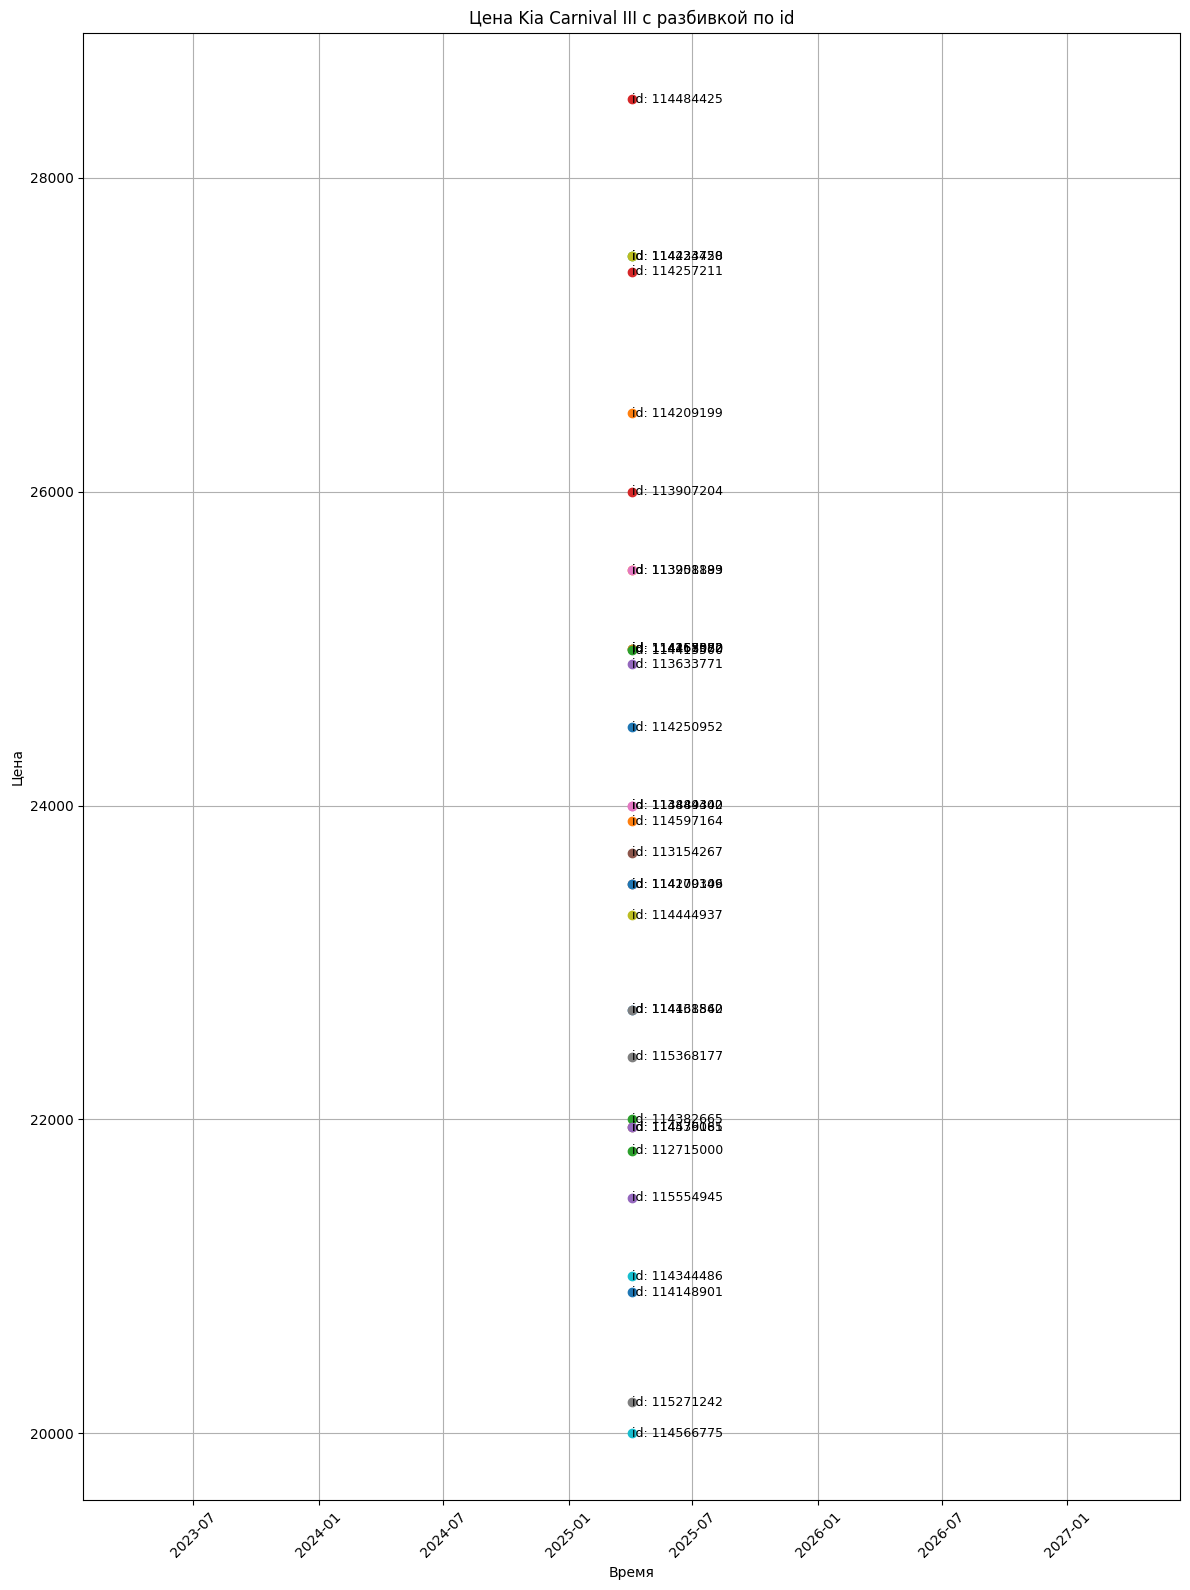

In [33]:
plot_price_by_date(kia_carnival_iii_history, 'Kia Carnival III')

In [34]:
kia_carnival_iii_insights = find_insights(kia_carnival_iii_history)
show_insights(kia_carnival_iii_insights)